# **Working with Earth Observation data in Python**

Welcome to this tutorial where we will cover a review on Rasterio,and introduce you to XArray.

## 1. RasterIO Basics

Rasterio provides easy ways to process and analyze different types of raster data used in the Geographic Information (GI) Science field. Geographic Information Systems use multiple different formats to store satellite images, terrain models, and much more. Rasterio reads/writes these formats using Python and its APIs.

### 1.1 Accessing and Understanding the Geospatial Raster data
The data we will be using for exploring Rasterio's features are the Landsat 8 data stored in **Cloud-Optimized GeoTIFF** (COG) format. COGS are normal geoTIFF files that are hosted on a cloud server and are optimized for remote reads. This data does not need to be downloaded on your local machine! Any operations on the data can be done cloud natively, meaning operations are performed in memory in Azure. 

For the introductory purposes of this notebook we will be reading in data from Google's cloud storage. However, going forward we recommend using Planetary Computer's STAC api, as the data costs will be reduced in so doing. How to access data in STAC servers as well as working with this data will be introduced in future notebooks.

In [1]:
# import the rasterio module, and the "show" function for plotting the maps
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

# Let's import all the bands we will be using for this section.
band1 = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/038/038/LC08_L1TP_038038_20200831_20200906_01_T1/LC08_L1TP_038038_20200831_20200906_01_T1_B1.TIF'
band2 = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/038/038/LC08_L1TP_038038_20200831_20200906_01_T1/LC08_L1TP_038038_20200831_20200906_01_T1_B2.TIF'
band3 = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/038/038/LC08_L1TP_038038_20200831_20200906_01_T1/LC08_L1TP_038038_20200831_20200906_01_T1_B3.TIF'
band4 = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/038/038/LC08_L1TP_038038_20200831_20200906_01_T1/LC08_L1TP_038038_20200831_20200906_01_T1_B4.TIF'


***What does the url mean? Let's break it down:***
- `https://storage.googleapis.com/` means the image is collected from Google's cloud storage.
- `gcp-public-data-landsat/` is the public folder containing sub-folders with all Landsat satellites.
- `LC08/01/` is the folder for the Landsat 8 Collection 1.
- `038/038/` means the images that cover the Landsat swath at path 38 and row 38, respectively.
- `LC08_L1TP_038038_20200831_20200906_01_T1/` is the folder containing all the bands for the image taken on August 31st, 2020.

Since we only want the RGB bands, we collect LC08_L1TP_038038_20200831_20200906_01_T1 bands 2, 3, and 4.

To start off, we will experiment by opening **band 2** from the Landsat 8 image taken on *August 31st, 2020, in the Bay region south of California, US in Northwestern Mexico.*

We can use the `with` statement which reads in the file and automatically closes the file once you are finished performing work on the file. `with` is also great at handling exceptions that may occur when the file handler has been obtained. To work with the raster data, rasterio has a `.open(filepath)` function which takes in the url as input to open the image. To actually read the data, `.read()` must be called, which will return a NumPy array depicting the raster.

*The parameter for read is 1, because our image contains a singular band. If an entire multispectral image is referenced, then other integers can be passed to read a particular band of the image.*

In [2]:
with rasterio.open(band2) as src: # src is the dataset reader
    ## Let's try and understand the image better.
    print(f'The raster is stored in a: {type(src.read(1))}')
    print(f'The data types: {src.read(1).dtype}')
    print(f'Image size is: {src.shape[0]} rows x {src.shape[1]} columns')
    print(f'The number of bands in the image: {src.count}')
    print(f'The projection: {src.crs}')
    print(f'The driver format: {src.driver}')
    print(f'The geographic transform of the image: \n{src.transform}\n')

    # We can most of this data directly from the image's metadata.
    print("Image metadata:")
    metadata = src.meta
    print(metadata) # shares the attributes of the image (the metadata)

The raster is stored in a: <class 'numpy.ndarray'>
The data types: uint16
Image size is: 7701 rows x 7551 columns
The number of bands in the image: 1
The projection: EPSG:32611
The driver format: GTiff
The geographic transform of the image: 
| 30.00, 0.00, 628185.00|
| 0.00,-30.00, 3629715.00|
| 0.00, 0.00, 1.00|

Image metadata:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7551, 'height': 7701, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 628185.0,
       0.0, -30.0, 3629715.0)}


If you look at the code block above, you will note multiple print statements nested in the `with` statement which opens band 2. These statements explain the raster band 2. The objects within the curly brackets `{}` are the methods of getting the information. For example, `src.crs` returns the CRS of the image, which is EPSG:32610. Most of this data can be accessed by calling the image's metadata. 
***Metadata*** is data describing the image data and it is important for preserving records of long-term datasets.

Now, since we are outside the with statement, attempting to read the datafile will result in an error.

**The line of code below WILL generate the "RasterioIOError: Dataset is closed."**

In [64]:
src.read(1) # this is meant to return an error

RasterioIOError: Dataset is closed: https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/038/038/LC08_L1TP_038038_20200831_20200906_01_T1/LC08_L1TP_038038_20200831_20200906_01_T1_B2.TIF

An alternative way for opening a raster image is to assign the `rasterio.open(<img>)` to a variable. *However*, this is not a recommended approach as it does not use a context manager and you have to manually **close** the files after you are done working with the data.

In [24]:
b2 = rasterio.open(band2)
b2.close()

### 1.2 Performing the task of clipping the image

Each of the Landsat 8 images cover a large region on Earth, and sometimes we only want to focus on a specific area of interest (AOI). The imported image can directly be clipped to the desired AOI using rasterio. 
Here, we create a function which takes the path of the image, and returns a clipped image around the specified bounding area given by rasterio's windows function. This is an efficient way to view just the subset of the image because it does not require the entire image to be processed, proving another reason for why Cloud-optimized GeoTIFFs are an optimal format.

Let's get started by opening **band 5** of a new Landsat 8 image taken on May 10th, 2020 in Southern British Columbia (path 47, row 26).

In [3]:
# NIR Spectral Band
band5 = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/047/026/LC08_L1TP_047026_20200510_20200526_01_T1/LC08_L1TP_047026_20200510_20200526_01_T1_B5.TIF'

In [4]:
def get_clipped_img(url):
    with rasterio.open(url) as src:
        row_offset, col_offset = src.index(474013,5458927) # coordinate collected using QGIS software.
                                                              # width, height
        window = rasterio.windows.Window(col_offset, row_offset, 4000, 2000)
        # read only the section specified by the window
        clipped = src.read(1, window=window) 
        show(clipped, cmap='terrain') # using the 'terrain' colormap
    return clipped

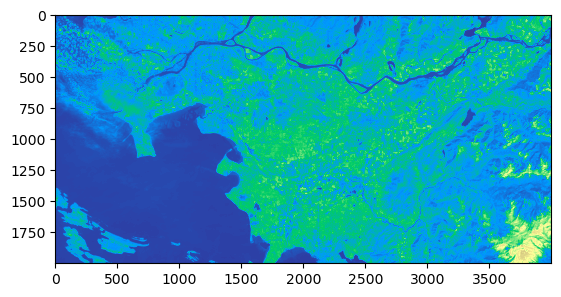

In [5]:
clipped_b5 = get_clipped_img(band5)

### 1.3 Performing calculations on the Raster Images
Doing computations on the raster data is an essential part of geospatial analysis, such as presenting the spectral indices of granules or even just normalizing the data for plotting purposed. Let's experiment by plotting a combination of Landsat bands to create an RGB True colour composite image. Let's begin by importing in the Red, Green, and Blue bands from the Landsat 8 image taken on *August 31st, 2020, in the Bay region south of California, US in Northwestern Mexico.*

Before we can plot the RGB image, the arrays must be normalized, only then can they be combined together. The array is normalized by dividing each array item by the total array maximum. (NumPy makes it quick to calculate with only 1 line, no for loop needed!) After that, using the NumPy `.dstack()` function to combine the three bands, we can plot the final RGB image.

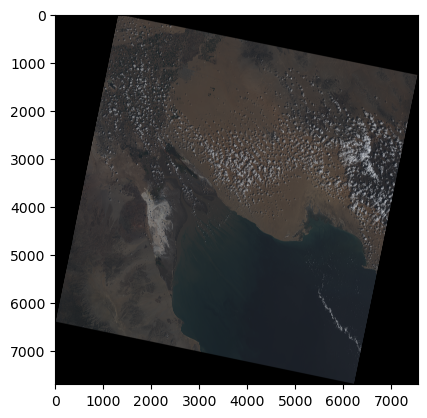

In [6]:
with rasterio.open(band2) as b2, rasterio.open(band3) as b3, rasterio.open(band4) as b4:
    # Read in the 3 bands
    blue = b2.read(1)
    green = b3.read(1)
    red = b4.read(1)
    
    # Normalize the numpy arrays
    redN = (red/red.max())*255
    greenN = (green/green.max())*255
    blueN = (blue/blue.max())*255
    
    # Stack the 3 bands together (order matters)
    rgb = np.dstack((redN, greenN, blueN)).astype(np.uint8)

    # Using matplotlib, let's see how the True colour image looks
    plt.imshow(rgb)
    plt.show()

Great! After normalizing our data and stacking them together we now have an image of the Northern region in the Gulf of California looking like a picture taken from a satellite.

## 2. XArray Basics

xarray is a Python package which makes it simple and efficient to work with *labelled multi-dimensional arrays*. It borrows the raw Numpy array structure with additional dimensions of labels, convenient for large datasets. xarray provides the basic data structures used for EO analysis, as well as powerful tools for computation and visualization. xarray distinguishes itself from many netCDF data tools as it provides data structures for in-memory analytics that both utilize and preserve dimensional labels. 

The two main xarray data structures are:
- **DataArray** - comprised of a labelled, multi-dimensional array with:
    * `values`: a numpy N-Dimensional array with the array values.
    * `dims`: the dimensions for each axis in the array. (for example, ('x', 'y', 'z') or ('time', 'space'))
    * `coords`: a dictionary type of container of array labelling each of the points.
    * `attrs`: dictionary keeping the metadata of the array.
    
- **Dataset** - comprised of multiple variables that can share the same coordinates (similar to Pandas Dataframes), with the properties:
    * `data_vars`: dictionary-like container of DataArrays.
    * `dims`: dictionary mapping the dimension names to the length of the dimensions. (for example, {'x': 2, 'y': 4, 'z': 3})
    * `coords`:  a dictionary type of container of DataArrays labelling each of the points in data_vars.
    * `attrs`: dictionary keeping the metadata of the array.


### 2.1 Reading in Data as DataArray

Let's get started with a quick example to understand how xarray works. We'll pass in band 2 from the raster image used in the Rasterio section. The band will be read in using xarray's `.open_rasterio(<filename>)` function. After that, we will convert the numpy array into an xarray DataArray of name 'blue' and plot the image using the native xarray `.plot()` function.

In [7]:
import xarray as xr

/tmp/ipykernel_1494/226097659.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  with xr.open_rasterio(band2) as src:


<xarray.DataArray 'blue' (dim_0: 1, dim_1: 7701, dim_2: 7551)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)
Dimensions without coordinates: dim_0, dim_1, dim_2


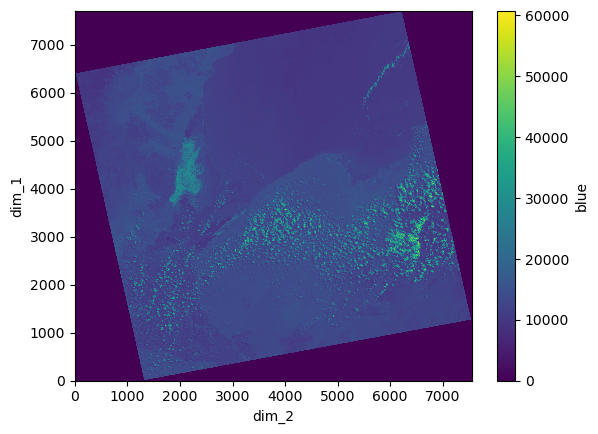

In [ ]:
with xr.open_rasterio(band2) as src:
    blue = src.data
    blue_da = xr.DataArray(blue, name='blue')
    print(blue_da)
    blue_da.plot()

### 2.2 Merging DataArrays into a Dataset

With complex data, the extra-multidimensionality of Datasets is sometimes necessary. We have already plotted an RGB image using Rasterio, now let's try to perform the same task using xarray functions by converting the bands from DataArrays together to one Dataset!

First let's initialize an empty dataset to which we will combine the DataArrays. Next, open all three bands (bands 2, 3, and 4) which make up Blue, Green, and Red, respectively. Similar to the Rasterio method, we must normalize the three bands so they can be stacked on the same scale. Then these NumPy arrays will be converted to DataArrays (as in the example above) before being merged to the Dataset. 


In [9]:
xr_ds = xr.Dataset()

with xr.open_rasterio(band2) as src:
    blue = src.data
    blueN = blue/blue.max()*255
    # blueND = blueN.astype(np.uint8)
    xr_ds = xr_ds.merge(xr.DataArray(blueN, name='b2'))
    
with xr.open_rasterio(band3) as src:
    green = src.data
    greenN = green/green.max()*255
    # greenND = greenN.astype(np.uint8)
    xr_ds = xr_ds.merge(xr.DataArray(greenN, name='b3'))
    
with xr.open_rasterio(band4) as src:
    red = src.data
    redN = red/red.max()*255
    # redND = redN.astype(np.uint8)
    xr_ds = xr_ds.merge(xr.DataArray(redN, name='b4'))

/tmp/ipykernel_1494/2566492551.py:3: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  with xr.open_rasterio(band2) as src:
/tmp/ipykernel_1494/2566492551.py:9: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  with xr.open_rasterio(band3) as src:
/tmp/ipykernel_1494/2566492551.py:15: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  with xr.open_rasterio(band4) as src:


Once the bands have been combined in one DataSet, we need to assign them as a separate Data Variable known as "rgb" which is the stacking of bands 4, 3, and 2 along their dimensions. 

In [10]:
xr_ds['rgb'] = (("dim0", "dim1", "dim2"), np.vstack([xr_ds.b4.data.astype(np.uint8),xr_ds.b3.data.astype(np.uint8),xr_ds.b2.data.astype(np.uint8)]))
xr_ds

<xarray.Dataset>
Dimensions:  (dim_0: 1, dim_1: 7701, dim_2: 7551, dim0: 3, dim1: 7701,
              dim2: 7551)
Dimensions without coordinates: dim_0, dim_1, dim_2, dim0, dim1, dim2
Data variables:
    b2       (dim_0, dim_1, dim_2) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    b3       (dim_0, dim_1, dim_2) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    b4       (dim_0, dim_1, dim_2) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rgb      (dim0, dim1, dim2) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

Now, we can plot the multi-band image using the "rgb" variable.

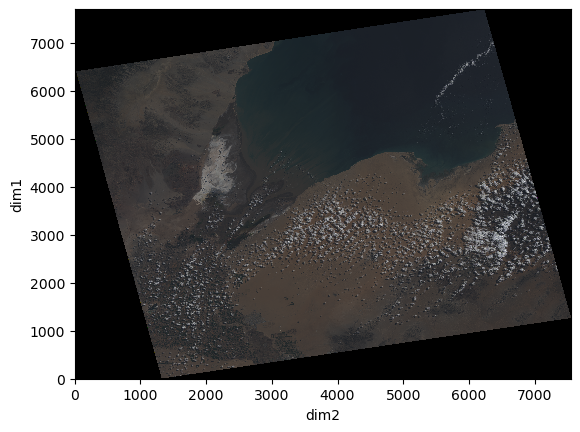

In [11]:
xr_ds.rgb.plot.imshow()

As we can see from the xarray displayed above, this dataset has six dimensions, three shared by the variables 'b2', 'b3', 'b4' (dim_0, dim_1, dim_2), and three for the combination of the bands for variable 'rgb' (dim0, dim1, dim2).

### 2.3 Types of Indexing
There are two main ways to index xarray DataArrays and Datasets, label-based indexing and position-based indexing.

**Label-based indexing**

Label-based index allows to access the information of a coordinate by calling its label. This feature is inspired by pandas method of indexing.

In [12]:
# Let's get the Dataset for one band from the layered RGB using dim0 to isolate 1 band.
xr_ds.sel(dim0=0)

<xarray.Dataset>
Dimensions:  (dim_0: 1, dim_1: 7701, dim_2: 7551, dim1: 7701, dim2: 7551)
Dimensions without coordinates: dim_0, dim_1, dim_2, dim1, dim2
Data variables:
    b2       (dim_0, dim_1, dim_2) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    b3       (dim_0, dim_1, dim_2) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    b4       (dim_0, dim_1, dim_2) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rgb      (dim1, dim2) uint8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

**Position-based indexing**

Position-based index takes after the method of NumPy array indexing, with the power of labelled dimensions. 

In [13]:
xr_ds.isel(dim_1=2, dim_2=5) 

<xarray.Dataset>
Dimensions:  (dim_0: 1, dim0: 3, dim1: 7701, dim2: 7551)
Dimensions without coordinates: dim_0, dim0, dim1, dim2
Data variables:
    b2       (dim_0) float64 0.0
    b3       (dim_0) float64 0.0
    b4       (dim_0) float64 0.0
    rgb      (dim0, dim1, dim2) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

### 2.4 Overlaying a Clipped Raster Image
Similar to how we used Rasterio's windows to select a subset of the image, let's create a numpy array which will contain the values for the clipped image. This array will be converted into a DataArray and merged with our existing Dataset. Let's read in a different band (band 1) of the same image to be clipped and overlay it on the full RGB data. 

In [14]:
with xr.open_rasterio(band1) as src:
    zero = np.zeros(src.data.shape)
    zero[:] = np.nan
    zero[:,3000:5000,2000:5000] = src.data[:,3000:5000,2000:5000]
    xr_ds = xr_ds.merge(xr.DataArray(zero, name='b1'))
xr_ds

/tmp/ipykernel_1494/3279054872.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  with xr.open_rasterio(band1) as src:


<xarray.Dataset>
Dimensions:  (dim_0: 1, dim_1: 7701, dim_2: 7551, dim0: 3, dim1: 7701,
              dim2: 7551)
Dimensions without coordinates: dim_0, dim_1, dim_2, dim0, dim1, dim2
Data variables:
    b2       (dim_0, dim_1, dim_2) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    b3       (dim_0, dim_1, dim_2) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    b4       (dim_0, dim_1, dim_2) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rgb      (dim0, dim1, dim2) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    b1       (dim_0, dim_1, dim_2) float64 nan nan nan nan ... nan nan nan nan

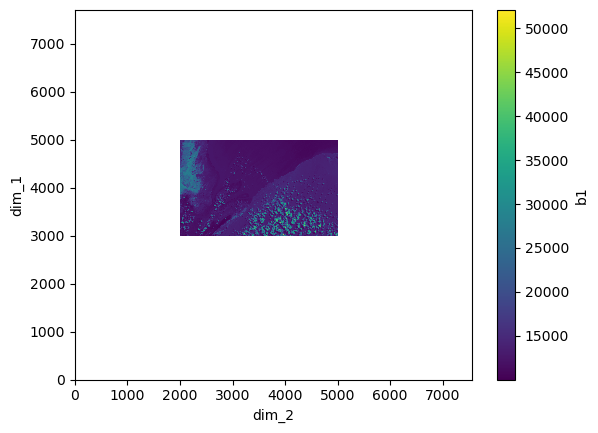

In [15]:
xr_ds.b1[0].plot.imshow() 

Now that we know how the clipped image and the full RGB image look in different plots, let's combine them together in one image. 

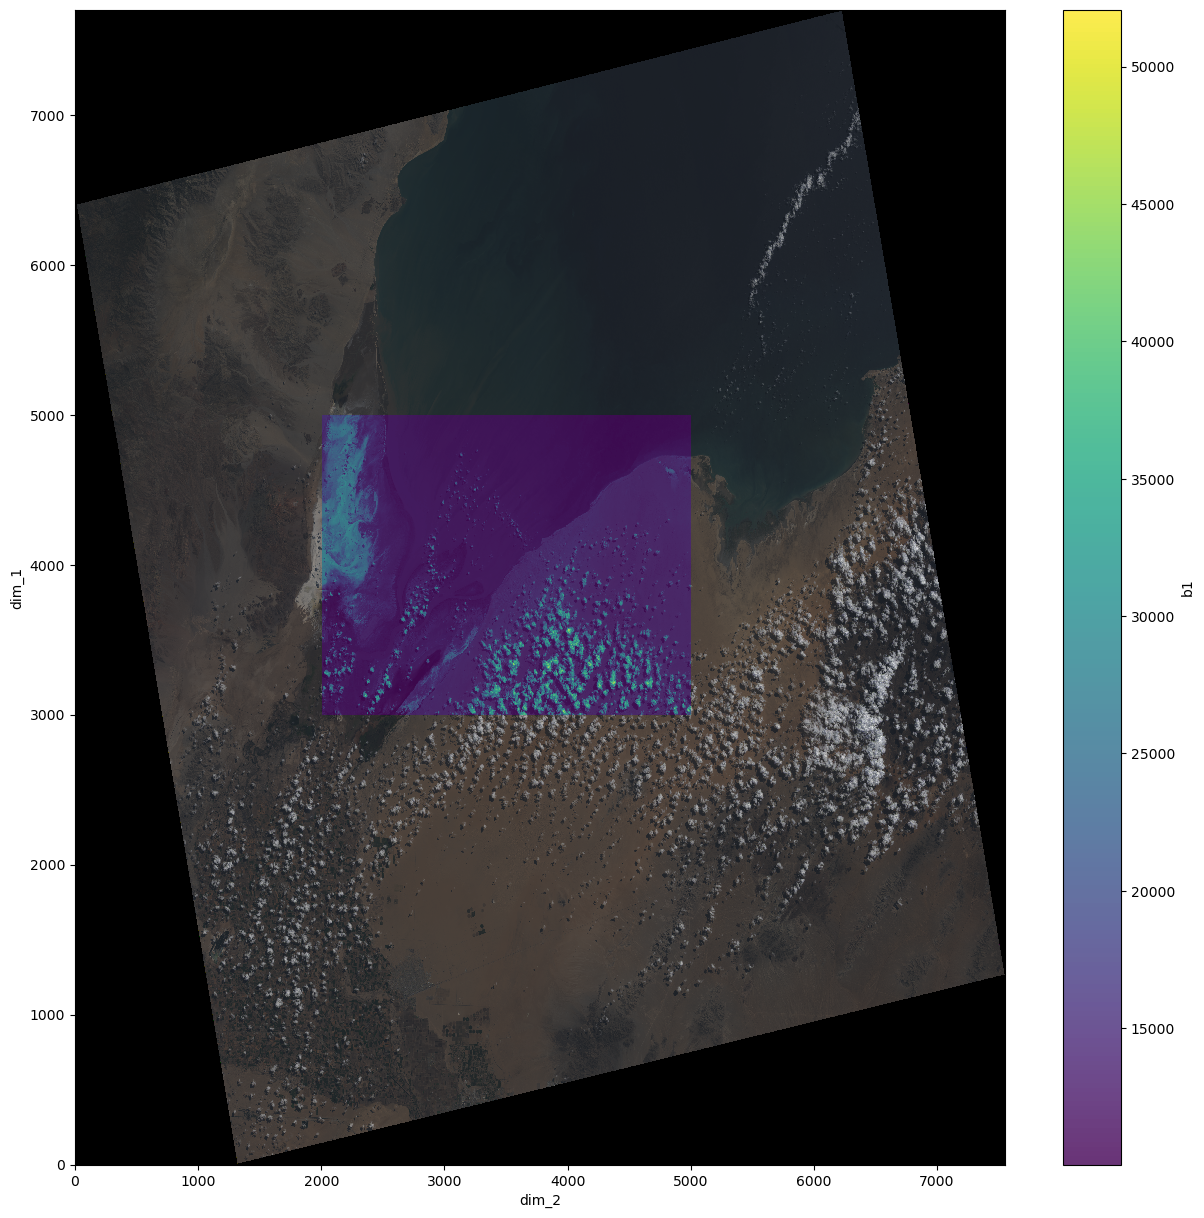

In [16]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
xr_ds.rgb.plot.imshow(ax=ax)
xr_ds.b1[0].plot.imshow(ax=ax, alpha=0.8)

The final merged dataset contains all four bands which plotted together look as the result above.

As you can see, xarray is great for working with large datasets that require efficient storage and more concision. In the next tutorial we will explore **Dask**, a library for distributed computing, which plays a key role for enhancing the powers of xarray.

## 3. Additional Documentations

**Rasterio**

* Documentation: https://rasterio.readthedocs.io/en/latest/

**xarray**

- xarray Fundamentals: https://rabernat.github.io/research_computing_2018/xarray.html
- Documentation: http://xarray.pydata.org/en/stable/index.html